In [14]:
import torch
import torchvision
import torchaudio 
import os
import torch.nn as nn
from os.path import isfile, join, isdir, exists
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

torch.manual_seed(0)
np.random.seed(0)

In [15]:
class MusicDataset(Dataset):

    def __init__(self, spec_dir, out_dir, years):
        self.spec_dir = spec_dir
        self.out_dir = out_dir
        self.ims = []
        self.labels = []
        self.names = []

        for dirs in years:
            for f in os.listdir(join(spec_dir, dirs)):
                if(isfile(join(join(out_dir, dirs), f))):
                    self.ims.append(join(join(spec_dir, dirs), f))
                    onm = join(out_dir, dirs)
                    self.labels.append(join(onm, f))
                    self.names.append(join(join(out_dir, dirs), f))
                    #print(join(join(spec_dir, dirs), f))
                    #print(join(onm, f))

    def __len__(self):
        return len(self.ims)

    def __getitem__(self, idx):
        #print(self.ims[idx])
        
        im, lab = torch.load(self.ims[idx]), torch.load(self.labels[idx])
        if(im.isnan().any()):
            print(self.names[idx])
        mean = torch.mean(im)
        std = torch.std(im)
        if(std==0):
            im = torch.zeros_like(im)
        else:
            im = (im-mean)/(std)

        if(im.isnan().any()):
            print(self.names[idx], "post", mean, std)
            im = torch.zeros_like(im)

        return im.T, lab


bs = 16
training_data = MusicDataset('mel/', 'mid/', ['2004', '2006', '2008', '2009', '2011', '2013', '2014'])
test_data = MusicDataset('mel/', 'mid/', ['2015', '2017', '2018'])
train_dataloader = DataLoader(training_data, batch_size=bs, shuffle=True, )
test_dataloader = DataLoader(test_data, batch_size=bs, shuffle=False)

In [16]:
import math
from typing import Tuple

import torch
from torch import nn, Tensor
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class Model(nn.Module):

    def __init__(self, ntoken: int, n_inputs: int, d_model: int, nhead: int, d_hid: int,
                 nlayers: int, dropout: float = 0.5):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder = nn.Linear(n_inputs, d_model)
        self.d_model = d_model
        self.decoder = nn.Linear(d_model, ntoken)
        self.us = nn.Upsample(size = (88*4, 7691), mode='bilinear')
        self.ll = nn.Conv1d(88*4, 88, 12)
        self.sugma = nn.Sigmoid()

    def forward(self, src: Tensor) -> Tensor:
        """
        Args:
            src: Tensor, shape [seq_len, batch_size]
            src_mask: Tensor, shape [seq_len, seq_len]

        Returns:
            output Tensor of shape [seq_len, batch_size, ntoken]
        """
        src = self.encoder(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        output = self.decoder(output)
        output = torch.unsqueeze(output, 1)
        
        output = self.us(output)
        output = self.ll(output.reshape(-1, 88*4, 7691))
        #print(output.shape)
        return self.sugma(output)


def generate_square_subsequent_mask(sz: int) -> Tensor:
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)


def loss_func(x, y):
    # metric = nn.BCELoss()
    # return metric(x.flatten(), (y.flatten()))
    x = torch.clip(x, min=1e-20, max=1-1e-20)
    if(x.isnan().any()):
        print("ANSH IS A GOON!")
    #return torch.mean(y*torch.log(x)*0.95 + (-1*y+1)*torch.log(-1*x+1)*0.05)*-1
    return torch.mean(y*torch.log(x) + (-1*y+1)*torch.log(-1*x+1))*-1

In [17]:
ntokens = 88*4
emsize = 200  # embedding dimension
d_hid = 200  # dimension of the feedforward network model in nn.TransformerEncoder
nlayers = 2  # number of nn.TransformerEncoderLayer in nn.TransformerEncoder
nhead = 2  # number of heads in nn.MultiheadAttention
dropout = 0.2 
n_inputs = 229


In [20]:
model = Model(ntokens, n_inputs, emsize, d_hid, nlayers, nhead, dropout)
model = model.to('cuda')
lr = 3e-4
optim = torch.optim.Adam(lr = lr, params = model.parameters())
save_epochs = 1
val_print_ep = 5
n_epochs = 100
losses = []
for i in range(n_epochs):
    print("starting epoch", i)
    total_loss = 0
    batch = 0
    intlosses = []
    for X, y in train_dataloader:
        print("batch progress", batch, len(train_dataloader))
        batch += 1
        if(batch % 30 == 0):
            torch.save({
            'epoch': i,
            'batch': batch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': intlosses,
            }, 'intermediate_save_no_weight_conv1d' + str(batch) + '.pt')
        
        #X = torch.unsqueeze(X, axis = 1)
        X = X.to('cuda')
        if(X.isnan().any()):
            print("HI")
        # print(X.shape)
        y = y.type(torch.float32).to('cuda')
        optim.zero_grad()
        pred = model(X)
        loss = loss_func(pred, y)
        print(loss.item())
        intlosses.append(loss.item())
        ##print(intlosses)
        total_loss += loss.item()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
        optim.step()
    losses.append(total_loss)
    print(total_loss)
    if (i % save_epochs == 0):
        torch.save({
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optim.state_dict(),
            'loss': losses,
            }, 'saved_data.pt')

    if (i % val_print_ep == 0):
        with torch.no_grad():
            total_loss = 0
            for X, y in test_dataloader:
                X = torch.unsqueeze(X, axis = 1)
                X = X.to('cuda')
                y = y.to('cuda')
                pred = model(X)
                loss = loss_func(y, pred)
                total_loss += loss
        print("Test error after epoch " + str(i) + ": " + str(total_loss/len(test_dataloader)))

starting epoch 0
batch progress 0 3147
0.7028594017028809
batch progress 1 3147
0.7211847901344299
batch progress 2 3147
0.7015891075134277
batch progress 3 3147
0.701960027217865
batch progress 4 3147
0.6969656944274902
batch progress 5 3147
0.6781300902366638
batch progress 6 3147
0.6406418681144714
batch progress 7 3147
0.5820418000221252
batch progress 8 3147
0.5116379261016846
batch progress 9 3147
0.4304463565349579
batch progress 10 3147
0.3617677390575409
batch progress 11 3147
0.29200467467308044
batch progress 12 3147
0.22943662106990814
batch progress 13 3147
0.19512945413589478
batch progress 14 3147
0.16298604011535645
batch progress 15 3147
0.1306634396314621
batch progress 16 3147
0.13585853576660156
batch progress 17 3147
0.14771783351898193
batch progress 18 3147
0.12126307189464569
batch progress 19 3147
0.11586812138557434
batch progress 20 3147
0.12297660857439041
batch progress 21 3147
0.13057906925678253
batch progress 22 3147
0.11993557959794998
batch progress 23

KeyboardInterrupt: 

torch.Size([1001, 229])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[[2.3386e-06, 2.3094e-06, 2.2631e-06,  ..., 1.2575e-04,
          1.2741e-04, 1.2831e-04],
         [3.8619e-05, 3.8085e-05, 3.7199e-05,  ..., 1.0758e-03,
          1.0924e-03, 1.1009e-03],
         [2.7897e-06, 2.7368e-06, 2.6635e-06,  ..., 1.3713e-04,
          1.3958e-04, 1.4149e-04],
         ...,
         [5.7371e-07, 5.6613e-07, 5.5368e-07,  ..., 6.1665e-05,
          6.2611e-05, 6.3160e-05],
         [8.2453e-08, 8.0960e-08, 7.8686e-08,  ..., 1.7869e-05,
          1.8224e-05, 1.8431e-05],
         [1.1695e-07, 1.1471e-07, 1.1109e-07,  ..., 2.0199e-05,
          2.0545e-05, 2.0750e-05]]]) tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..

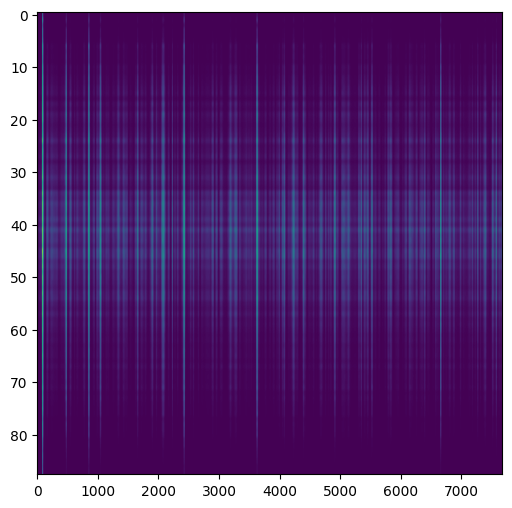

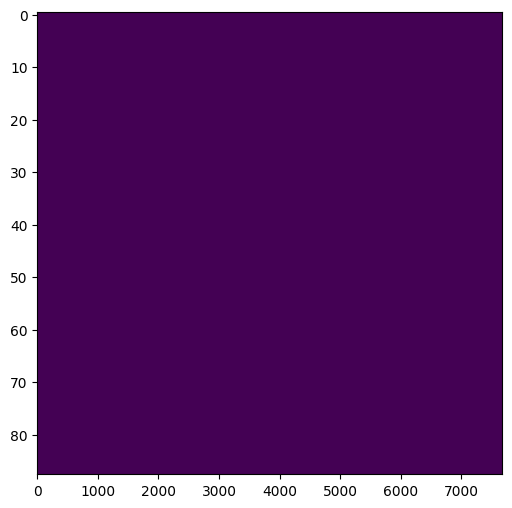

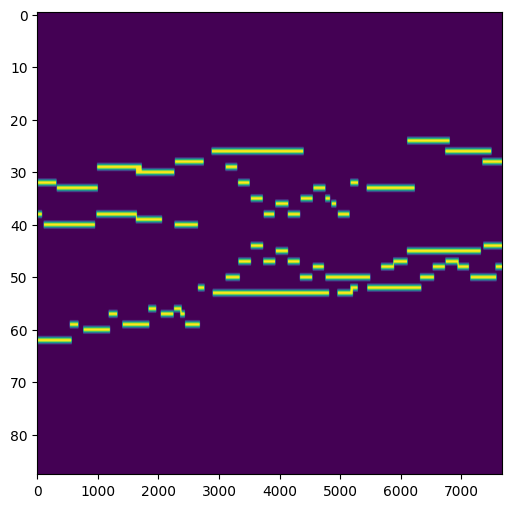

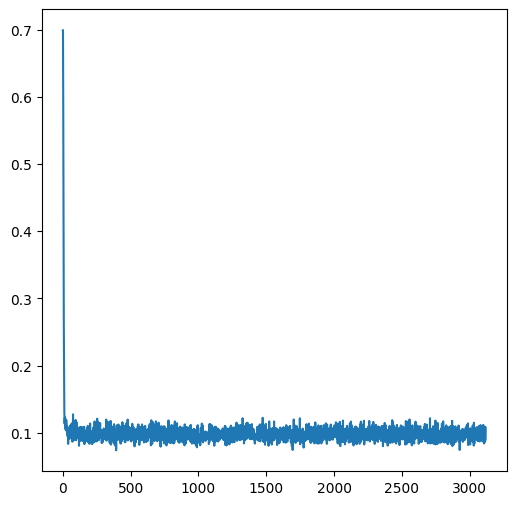

In [21]:
tt = DataLoader(test_data, batch_size=1, shuffle=False)
meval = Model(ntokens, n_inputs, emsize, d_hid, nlayers, nhead, dropout).to('cuda')
checkpoint = torch.load('intermediate_save_no_weight_conv1d3120.pt')
meval.load_state_dict(checkpoint['model_state_dict'])
meval.train()
fname = "mel/2017/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1_3.pt"
X = torch.load(fname).T
print(X.shape)
fname = "mid/2017/MIDI-Unprocessed_041_PIANO041_MID--AUDIO-split_07-06-17_Piano-e_1-01_wav--1_3.pt"
y = torch.load(fname).type(torch.float32)
X = torch.unsqueeze(X, axis = 0)

# X = X.to('cuda')
# y = y.to('cuda')
# print(nn.CrossEntropyLoss()(y, pred[0, :, :]))

with torch.no_grad():    
    pred = meval(X.to('cuda')).to('cpu')
    #print(nn.BCELoss()(pred[0, :, :], y))

print(np.round(pred.to('cpu')))

print(pred, y)
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(pred[0, :, :], aspect='auto')
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(np.round(pred[0, :, :]), aspect='auto')
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(y, aspect='auto')
# print(y.shape, pred.shape)
fig, ax = plt.subplots(figsize=(6,6))   
ax.plot(checkpoint['loss'])
print(torch.max(pred))